In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU
from tensorflow.keras.optimizers import Adam
from scipy.stats import norm
from scipy.linalg import svd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os 

# Fetch stock data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Compute technical indicators
def compute_technical_indicators(data):
    data['SMA30'] = data['Close'].rolling(window=3).mean()
    data['SMA100'] = data['Close'].rolling(window=5).mean()
    vol_window = 3
    data['Volatility'] = data['Close'].pct_change().rolling(window=vol_window).std() * np.sqrt(252)
    return data.dropna()

# Black-Scholes option pricing model
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Apply Black-Scholes model to generate option prices
def add_option_pricing_features(data):
    strike_price = data['Close'] * 1.05
    time_to_maturity = 30 / 252
    risk_free_rate = 0.01
    option_type = 'call'
    data['Option_Price'] = black_scholes(data['Close'], strike_price, time_to_maturity, risk_free_rate, data['Volatility'], option_type)
    data['Implied_Volatility'] = data['Volatility']
    return data

# Normalize and apply PCA for dimensionality reduction
def preprocess_data(data, n_pca_components=2):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    # pca = PCA(n_components=n_pca_components)
    # data_pca = pca.fit_transform(data_scaled)
    # return np.hstack((data_scaled, data_pca))
    return data_scaled, scaler

# Create sequences for time-series prediction
def create_sequences(data, seq_len, pred_len):
    sequences = []
    for i in range(len(data) - seq_len - pred_len + 1):
        sequences.append(data[i:i + seq_len + pred_len])
    return np.array(sequences)

# Function to create a Hankel matrix
def create_hankel_matrix(time_series, window_size):
    # Create a Hankel matrix where the columns are shifted versions of the time series
    hankel_matrix = np.array([time_series[i:i + window_size] for i in range(len(time_series) - window_size + 1)])
    return hankel_matrix

# Function to perform SVD on the Hankel matrix
def hankel_svd(hankel_matrix):
    # Perform SVD on the Hankel matrix
    U, Sigma, Vt = svd(hankel_matrix, full_matrices=False)
    return U, Sigma, Vt

# Build a neural network model
def build_model(input_shape, output_len):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(180),
        LeakyReLU(),
        Dense(360),
        LeakyReLU(),
        Dense(360),
        LeakyReLU(),
        Dense(output_len)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model



def predict_and_plot(m, ticker, data, s, model, seq_len, pred_len, scaler, cut_off):
    plt.figure(figsize=(14, 7))

    rmse_values = []  # To store RMSE values for each section
    section_start_idx = []  # To store the start indices of each 30-day section for placement of RMSE labels
    #s.shape[0]
    pred_count = 0
    red_x,red_y, black_y, blue_x, blue_y, green_y = [],[],[],[],[],[]
    for idx in range(0,s.shape[0], pred_len):  # Loop through each 30-day block
    # for idx in range(1): # only first 30 after being trained
        # Input remains in 3D for predictio
        future_input = s[idx, :seq_len, :].reshape(1, seq_len, -1)  # Keep the 3D shape
        future = model.predict(future_input)[0]  # Predict future "Close" prices
        # Pad the prediction with zeros for the "Volume" and "SMA" columns
        future_padded = np.hstack((future.reshape(-1, 1), np.zeros((future.shape[0], data.shape[1] - 1))))  # Adjust for PCA features

        # Inverse transform the padded prediction
        future_transform = scaler.inverse_transform(future_padded)[:, 0]  # Extract "Close"

        # Extract and inverse transform the true "Close" values
        future_true = s[idx, seq_len:, 0].reshape(-1, 1)  # Use only "Close"
        future_true_padded = np.hstack((future_true, np.zeros((future_true.shape[0], data.shape[1] - 1))))  # Adjust for PCA features
        future_true_transform = scaler.inverse_transform(future_true_padded)[:, 0]  # Extract "Close"

        # Calculate RMSE for this 30-day section
        percent_error = np.mean(np.abs((future_true_transform - future_transform) / future_true_transform)) * 100
        rmse_values.append(percent_error)
        section_start_idx.append(idx)  # Store the start index for the percentage error label
        if idx< cut_off:
            red_x +=[idx]
            red_y+=[future_transform]
            black_y+=[future_true_transform]
        else:
            blue_x +=[idx]
            blue_y+=[future_transform]
            green_y+=[future_true_transform]

        # # Plot the predictions
        # plt.scatter(idx, future_transform, 
        # # label="Train Prediction" if idx < cut_off else "Test Prediction", 
        #     color="red" if idx < cut_off else "blue")


        # # plt.plot(np.arange(idx, idx + pred_len), future_transform, 
        # #         # label="Train Prediction" if idx < cut_off else "Test Prediction", 
        # #          color="red" if idx < cut_off else "blue")

        # # Plot the true values
        # plt.scatter(idx, future_true_transform, 
        #          #label="Train True" if idx < cut_off else "Test True", 
        #          color="black" if idx < cut_off else "green")

        
        if idx >= cut_off:
            pred_count+=1
    plt.plot(red_x, red_y, color = "red")
    plt.plot(red_x, black_y, color = "black")
    plt.plot(blue_x, blue_y, color = "blue")
    plt.plot(blue_x, green_y, color = "green")
    # Add legend and grid
    # plt.legend(["Train Prediction", "Train True", "Test Prediction", "Test True"])
    plt.plot([], [], color="red", label="Train Prediction")  # Dummy plot for legend
    plt.plot([], [], color="black", label="Train True")      # Dummy plot for legend
    plt.plot([], [], color="blue", label="Test Prediction")  # Dummy plot for legend
    plt.plot([], [], color="green", label="Test True")      # Dummy plot for legend
    plt.legend()
    # for idx in range(0, s.shape[0], pred_len): 
    # Add vertical line to separate each 30-day section
        # plt.axvline(x=idx + pred_len, color='gray', linestyle='--', linewidth=1)
    # Title and labels
    
    plt.title(f"{seq_len}-{pred_len} Predictions for {ticker}, model {m}")
    plt.xlabel("Trading Days")
    plt.ylabel("Price")

    # Add RMSE labels below the x-axis at the start of each 30-day section
    # for i, rmse in zip(section_start_idx, rmse_values):
    #     plt.text(i + pred_len / 2, min(plt.ylim()), f"{rmse:.0f}", color="teal", fontsize=10, ha='center', va='top')
    # plt.text(- 5- pred_len / 2, min(plt.ylim()), f"RMSE", color="teal", fontsize=10, ha='center', va='top')
    # print(rmse_values)
    # plt.grid(True)
    if m == "NN w/ 1 feature":
        dir = f"{seq_len}-{pred_len}/nn_1"
        if not os.path.exists(dir):
                os.makedirs(dir)
        plt.savefig(f"{dir}/{ticker}.png")
    return rmse_values[-1] # testing rmse

    # plt.show()

# Call the function


# Main workflow
def main(tickers):
    m = "NN w/ 1 feature"
    test_rmse = []
    for ticker in tickers:
        # Step 1: Fetch data
        tsla = fetch_stock_data(ticker, start_date="2024-11-03", end_date="2024-12-02")

        # Step 2: Compute indicators
        tsla = compute_technical_indicators(tsla)

        # Step 3: Add Black-Scholes option pricing
        # tsla = add_option_pricing_features(tsla)

        # Step 4: Prepare data for training
        features = ['Close']#, 'Volume', 'SMA30', 'SMA100', 'Volatility']
        data = tsla[features].copy()
        # # Step 5: Perform Hankel Matrix Decomposition
        # window_size = 50  # Size of the sliding window to form the Hankel matrix
        # hankel_matrix = create_hankel_matrix(data['Close'].values, window_size)

        # # Step 6: Perform SVD on the Hankel matrix
        # U, Sigma, Vt = hankel_svd(hankel_matrix)

        # # You can choose the first few singular values and modes to add as features
        # num_modes = 2  # Number of modes to add as features
        # dmd_modes = U[:, :num_modes]  # Select the modes
        # dmd_amplitudes = Sigma[:num_modes]  # Select the amplitudes

        # # Step 7: Normalize and apply PCA for dimensionality reduction
        processed_data,scaler = preprocess_data(data)

        # # Trim the processed_data to match the number of rows in dmd_modes
        # processed_data_trimmed = processed_data[-dmd_modes.shape[0]:]  # Trim to match the length of dmd_modes

        # # Combine the Hankel decomposition modes with the processed data
        # data_combined = np.hstack((processed_data_trimmed, dmd_modes))

        # Step 8: Create sequences for time-series prediction
        seq_len =1  # 6 months of data
        pred_len = 1  # Predict the next 20 days
        sequences = create_sequences(processed_data, seq_len, pred_len)

        # Step 9: Split data into training and testing
        cut_off = int(0.8 * sequences.shape[0])
        X_train = sequences[:cut_off, :seq_len, :]
        X_test = sequences[cut_off:, :seq_len, :]
        y_train = sequences[:cut_off, seq_len:, 0]
        y_test = sequences[cut_off:, seq_len:, 0]
        print(sequences.shape)
        
        # Step 10: Build and train the model
        model = build_model(input_shape=(seq_len, X_train.shape[2]), output_len=pred_len)
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            verbose=1
        )

        test_rmse += [predict_and_plot(m, ticker, processed_data, sequences, model, seq_len, pred_len, scaler, cut_off)]

    mse_for_model  = np.mean(test_rmse)
    return mse_for_model

[*********************100%***********************]  1 of 1 completed
/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


(14, 2, 1)
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step - loss: 0.4380
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2541
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1437
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1102
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1498
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1701
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1498
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1210
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1052
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1055
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1135
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1188
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1170
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1100
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1014
Epoch 1

[*********************100%***********************]  1 of 1 completed

(14, 2, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step - loss: 0.4990
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2141
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0818
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0912
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1516
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1455
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1055
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0754
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0702
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0827
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0964
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1009
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0956
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0853
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0753
Epoch 16/100
1/1 ━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(14, 2, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step - loss: 0.2466
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1136
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0502
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0594
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0873
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0797
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0592
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0466
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0466
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0539
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0596
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0595
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0554
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0501
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0461
Epoch 16/100
1/1 ━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(14, 2, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step - loss: 0.2404
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1339
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0788
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0756
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0992
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1001
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0858
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0730
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0688
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0716
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0760
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0778
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0763
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0726
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0687
Epoch 16/100
1/1 ━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(14, 2, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step - loss: 0.2276
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1278
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0682
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0521
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0744
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0845
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0731
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0583
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0512
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0535
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0594
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0624
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0609
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0569
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0529
Epoch 16/100
1/1 ━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(14, 2, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step - loss: 0.4066
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2359
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1379
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1138
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1507
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1637
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1432
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1189
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1079
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1104
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1179
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1218
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1196
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1131
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1058
Epoch 16/100
1/1 ━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(14, 2, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step - loss: 0.3770
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1941
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0820
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0373
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0600
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0908
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0840
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0592
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0406
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0375
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0459
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0554
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0579
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0536
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0463
Epoch 16/100
1/1 ━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(14, 2, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step - loss: 0.3990
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1957
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0906
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0794
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1241
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1311
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1060
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0812
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0715
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0752
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0839
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0894
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0888
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0838
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0771
Epoch 16/100
1/1 ━━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(14, 2, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step - loss: 0.2160
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1165
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0729
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0820
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0991
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0915
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0767
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0688
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0701
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0750
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0771
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0752
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0711
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0672
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0651
Epoch 16/100
1/1 ━━━━━━━━━━━━

[*********************100%***********************]  1 of 1 completed

(14, 2, 1)
Epoch 1/100



/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step - loss: 0.5740
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3037
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1360
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0609
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0848
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1376
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1384
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1046
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0716
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0582
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0647
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0789
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0876
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0865
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0782
Epoch 16/100
1/1 ━━━━━━━━━━━━━

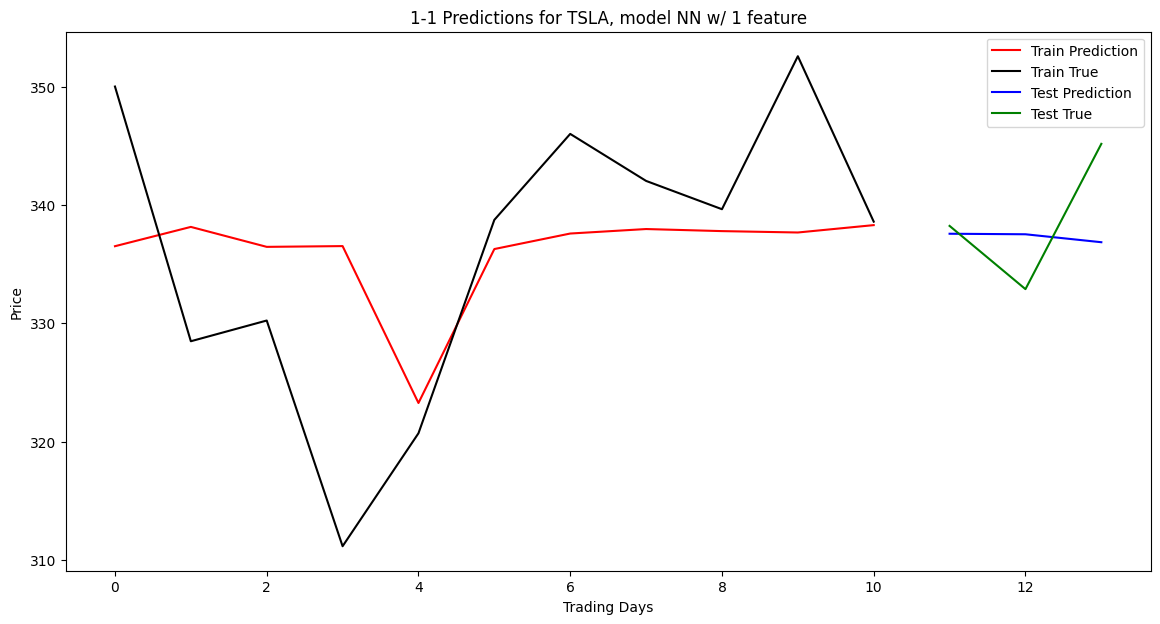

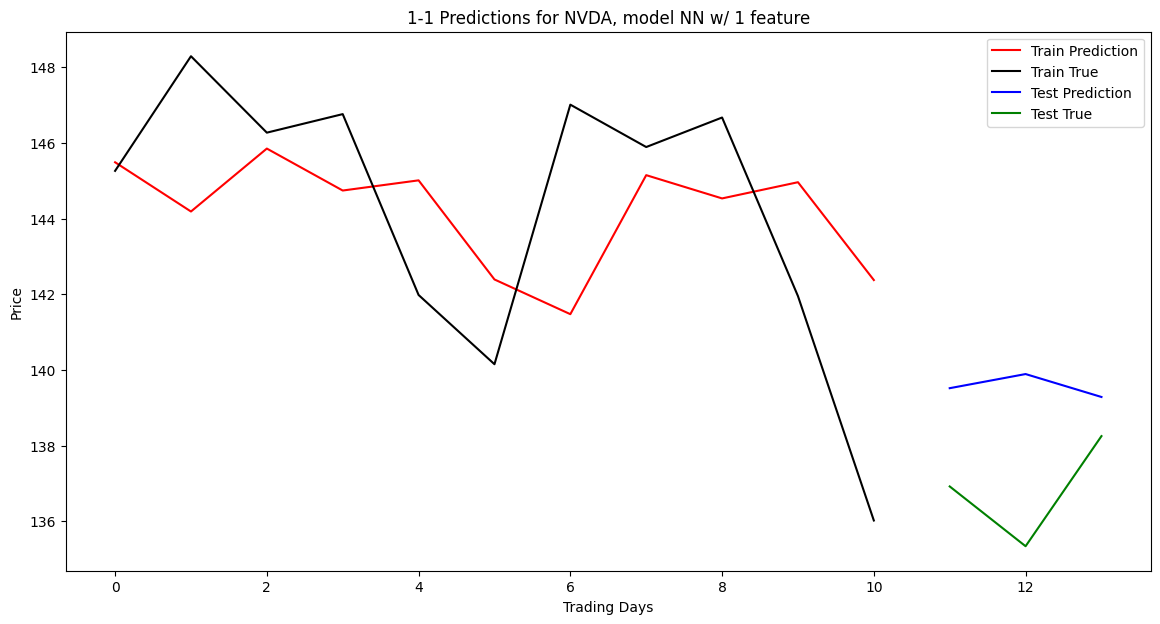

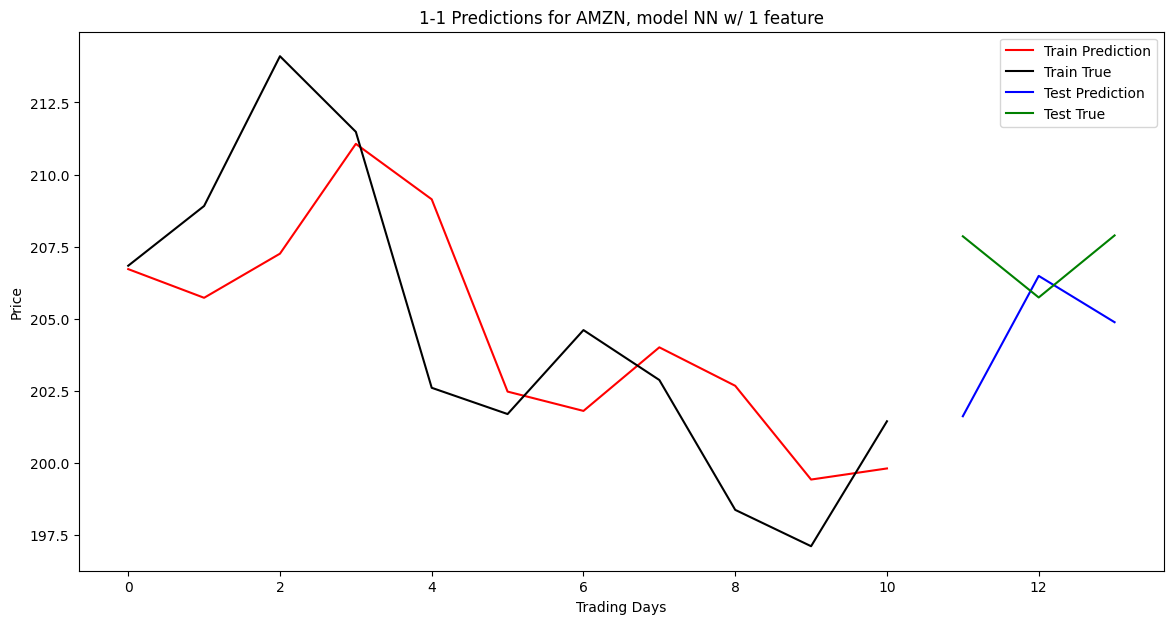

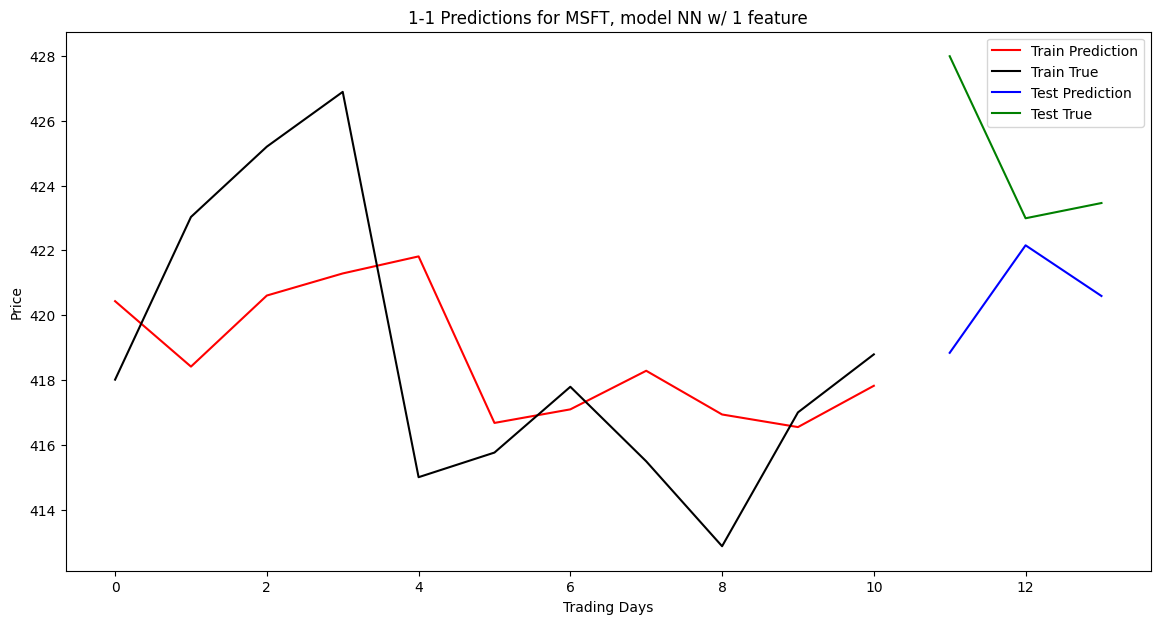

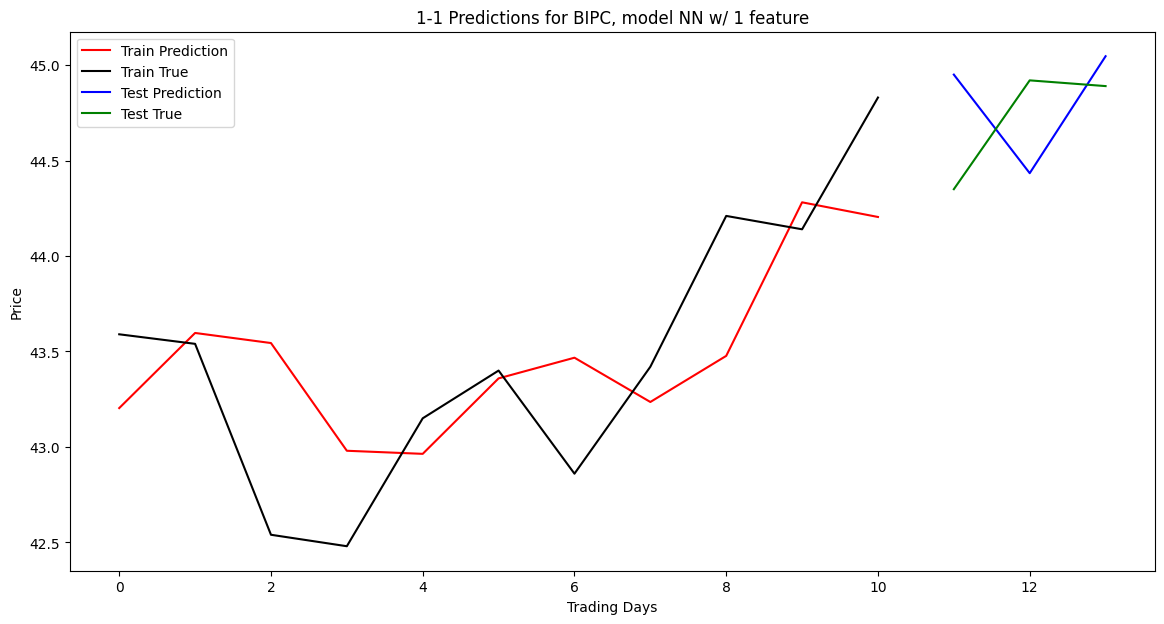

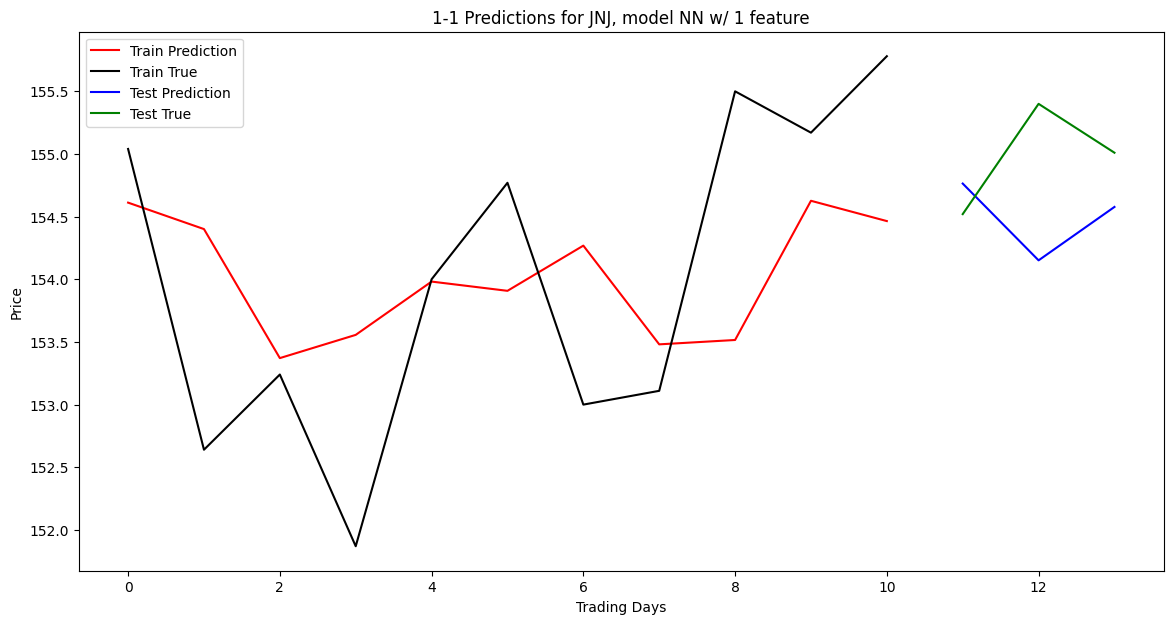

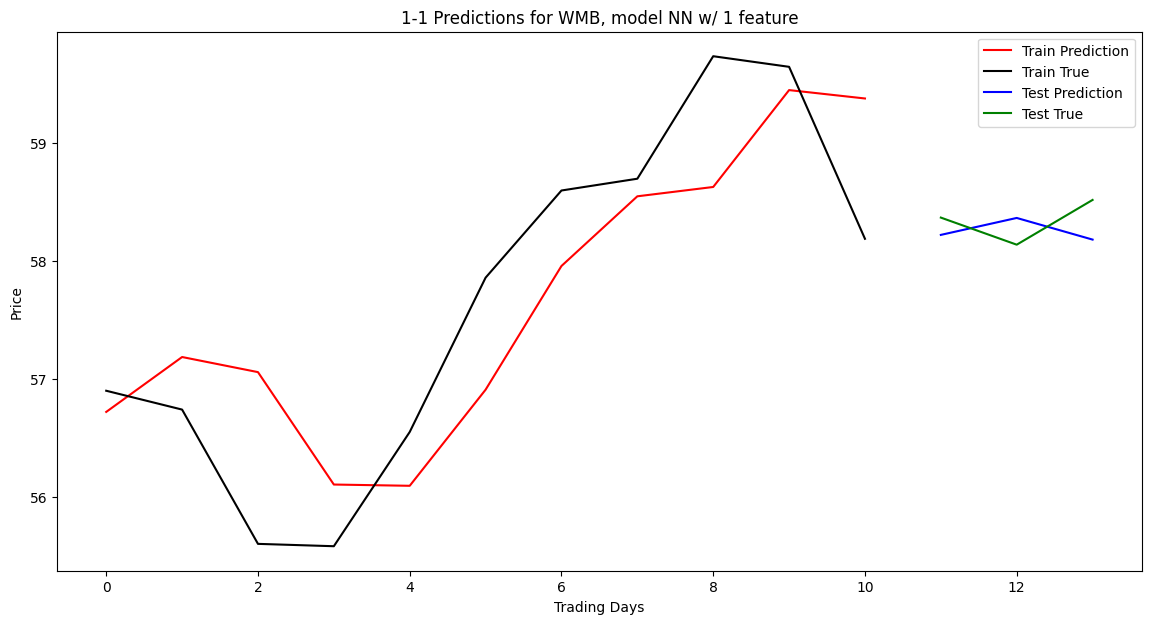

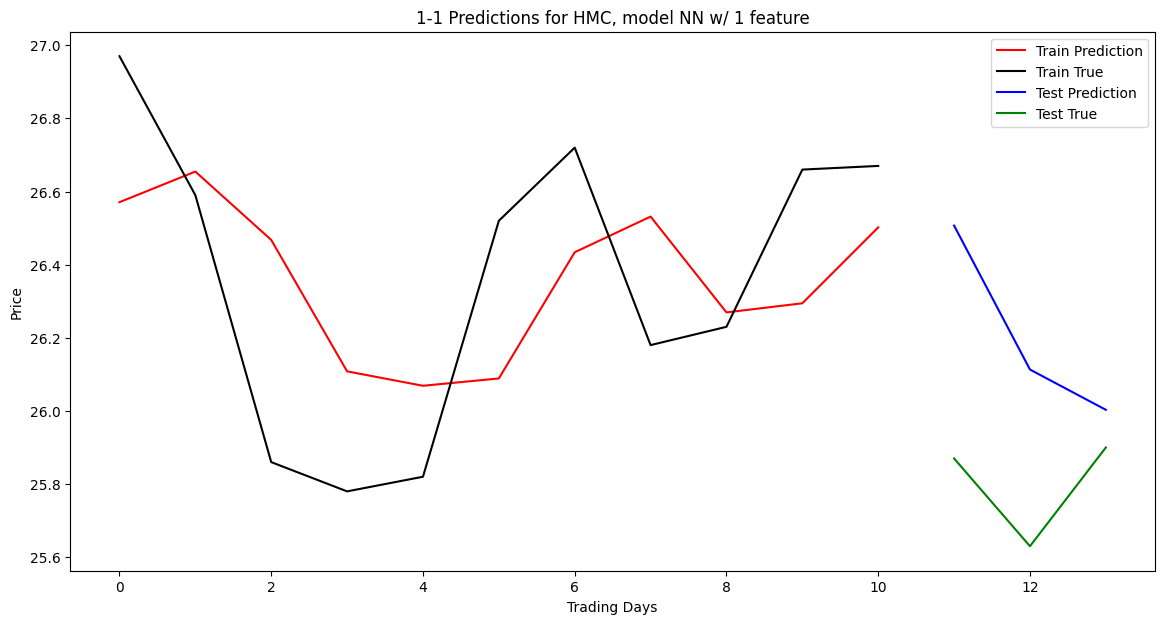

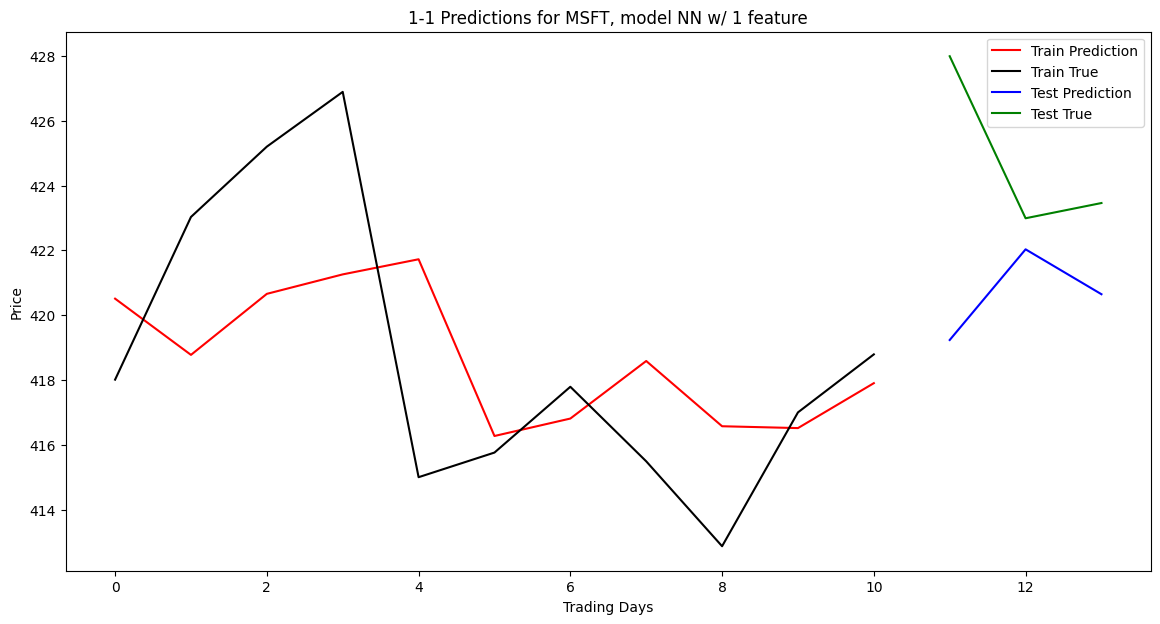

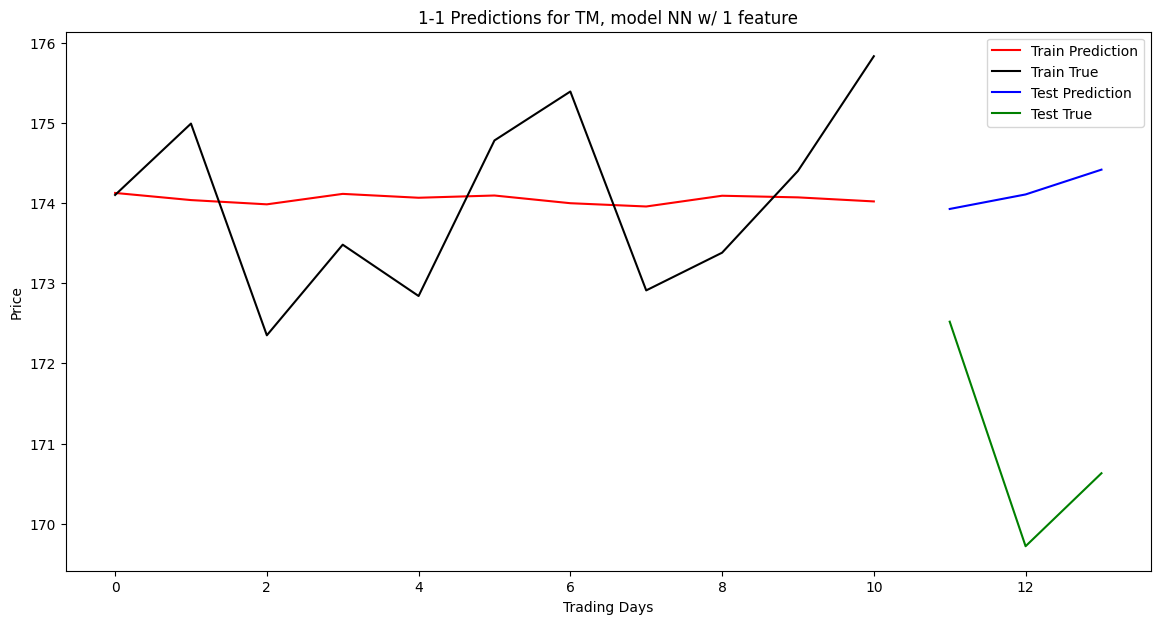

In [5]:
tickers = ["TSLA","NVDA","AMZN","MSFT", "BIPC", "JNJ","WMB","HMC","MSFT", "TM"]
mse = main(tickers)

In [6]:
mse

0.9763251398653733